In [1]:
import pandas as pd
# I only need first four columns
df = pd.read_csv('Usage data.csv', usecols=[0,1,2,3,4])
# I want to read data from rows 88 to 605
df = df.iloc[86:605]
df.head()

,TimeStamp,ResourceType,ResourceID,Effectiveness,Percentage
86,01-Jan-22,Cloud Storage,Data Scenarios,Cost,30.0
87,02-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0
88,03-Jan-22,Cloud Storage,Data Scenarios,Cost,31.0
89,04-Jan-22,Cloud Storage,Data Scenarios,Cost,37.0
90,05-Jan-22,Cloud Storage,Data Scenarios,Cost,33.0


In [2]:
# Delete column ResourceType, ResourceId, and Effectiveness from the dataframe
df = df.drop(['ResourceType', 'ResourceID', 'Effectiveness'], axis=1)
df.head()

,TimeStamp,Percentage
86,01-Jan-22,30.0
87,02-Jan-22,33.0
88,03-Jan-22,31.0
89,04-Jan-22,37.0
90,05-Jan-22,33.0


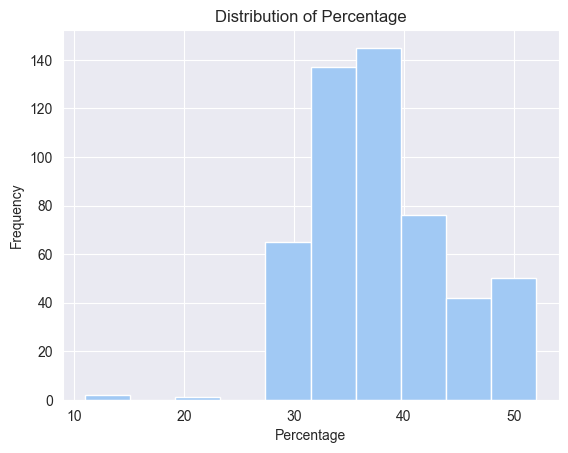

In [6]:
# find distribution of the percentage column using graph
import matplotlib.pyplot as plt
import seaborn as sns
plt.hist(df['Percentage'])
sns.set_palette('pastel')
sns.set_style('darkgrid')
plt.xlabel('Percentage')
plt.ylabel('Frequency')
plt.title('Distribution of Percentage')
plt.show()

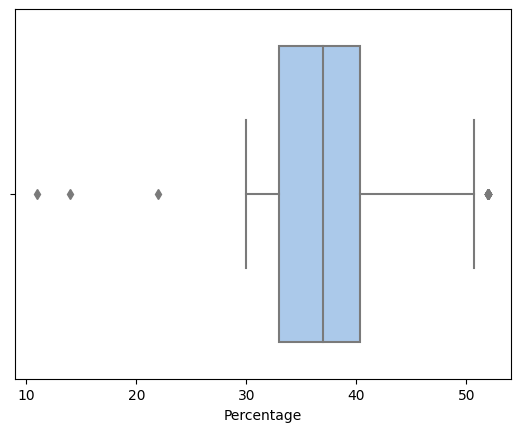

In [4]:
#create a box plot to find outliers
sns.boxplot(x=df['Percentage'])
plt.show()

In [7]:
#make first column as index
df.set_index('TimeStamp', inplace=True)
df.head()

,Percentage
TimeStamp,
01-Jan-22,30.0
02-Jan-22,33.0
03-Jan-22,31.0
04-Jan-22,37.0
05-Jan-22,33.0


In [18]:
Q1 = df.quantile(0.20)
Q3 = df.quantile(0.80)
IQR = Q3 - Q1

In [19]:
((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).sum()

Percentage    2
dtype: int64

In [20]:
# show the outliers
df[((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

,Percentage
TimeStamp,
05-Nov-22,11.0
01-Dec-22,14.0
